#### Librerias

In [1]:
import glob
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer

/home/jjmov99/universidad/proyecto_redes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


#### Path de los datos

In [2]:
DATA = Path("../data/codigo_penal/text")

#### Inspeccionar data

In [3]:
file_list = sorted(glob.glob(f"{DATA}/*.txt"), key=lambda x: int(re.search(r"\d+", x).group()))
file_list

['../data/codigo_penal/text/cleaned_output_1.txt',
 '../data/codigo_penal/text/cleaned_output_2.txt',
 '../data/codigo_penal/text/cleaned_output_3.txt',
 '../data/codigo_penal/text/cleaned_output_4.txt',
 '../data/codigo_penal/text/cleaned_output_5.txt',
 '../data/codigo_penal/text/cleaned_output_6.txt',
 '../data/codigo_penal/text/cleaned_output_7.txt',
 '../data/codigo_penal/text/cleaned_output_8.txt',
 '../data/codigo_penal/text/cleaned_output_9.txt',
 '../data/codigo_penal/text/cleaned_output_10.txt',
 '../data/codigo_penal/text/cleaned_output_11.txt',
 '../data/codigo_penal/text/cleaned_output_12.txt',
 '../data/codigo_penal/text/cleaned_output_13.txt',
 '../data/codigo_penal/text/cleaned_output_14.txt',
 '../data/codigo_penal/text/cleaned_output_15.txt',
 '../data/codigo_penal/text/cleaned_output_16.txt',
 '../data/codigo_penal/text/cleaned_output_17.txt',
 '../data/codigo_penal/text/cleaned_output_18.txt',
 '../data/codigo_penal/text/cleaned_output_19.txt',
 '../data/codigo_pena

#### Cargar los datos

In [4]:
# Leer los archivos y guardarlos en una lista
docs = []
for file in file_list:
    with open(file, "r") as f:
        content = f.read()
        docs.append(content)
print(f"Numero de paginas del codigo penal: {len(docs)}")

Numero de paginas del codigo penal: 20


#### Preparar datos

In [5]:
# Se inspecciona el primer documento
print(docs[0][:5000])

LEY 599 DE 2000 
(julio 24) 
Diario Oficial No. 44.097 de 24 de julio de 2000 
<ADVERTENCIA: Ver el Resumen de Notas de Vigencia en relación con los criterios adoptados por el editor para calcular los aumentos de penas de que trata el Artículo 14 de la Ley 890 de 2004. 
Sobre el particular, el editor destaca que en la comunidad jurídica del país existen diferentes interpretaciones sobre el alcance de la siguiente frase del Artículo 14 de la Ley 890 de 2004: "Las penas previstas en los tipos penales contenidos en la Parte Especial del Código Penal ..."
La interpretación del editor se basa en la claridad del texto del Artículo 14 de la Ley 890 de 2004 y en las definiciones contenidas en los Artículos 35 y 43 del Código Penal (Ley 599 de 2000)>
<Según lo dispuesto por el Artículo 476 este Código entra a regir un (1) año después de su promulgación.>
EL CONGRESO DE COLOMBIA 
Por la cual se expide el Código Penal 
Resumen de Notas de Vigencia

Notas del Editor
- Destaca el editor lo dispuest

- Los datos tienen una division natural de 4 nuevas lineas (`\n`), por ende, se pueden separar en parrafos.

In [6]:
# Dividir los datos
split_by = "\n\n\n\n"

splitted_docs = [split_doc.strip() for doc in docs for split_doc in doc.split(split_by)]
splitted_docs = [splitted_doc for splitted_doc in splitted_docs if splitted_doc.startswith("ARTÍCULO")]
print(f"Numero de parrafos finales: {len(splitted_docs)}")

Numero de parrafos finales: 551


In [7]:
pattern = "(^ARTÍCULO.*?\.)"
new = []
for doc in splitted_docs:
    splits = re.split(pattern, doc)[1:]
    new.extend([{"articulo": splits[0], "text": splits[1]}])

#### Construir el dataset

In [9]:
# Se crea el dataset
dataset = Dataset.from_list(new)
dataset

Dataset({
    features: ['articulo', 'text'],
    num_rows: 551
})

In [10]:
# Ejemplo 1
dataset[50]

{'articulo': 'ARTÍCULO 50.',
 'text': ' LA PRIVACIÓN DEL DERECHO A RESIDIR O DE ACUDIR A DETERMINADOS LUGARES. La privación del derecho a residir o de acudir a determinados lugares, impide al penado volver al lugar en que haya cometido la infracción, o a aquel en que resida la víctima o su familia, si fueren distintos.'}

In [11]:
# Ejemplo 2
dataset[100]

{'articulo': 'ARTÍCULO 101.',
 'text': " GENOCIDIO. <Penas aumentadas por el artículo 14 de la Ley 890 de 2004, a partir del 1o. de enero de 2005. El texto con las penas aumentadas es el siguiente:> <Aparte tachado INEXEQUIBLE> El que con el propósito de destruir total o parcialmente un grupo nacional, étnico, racial, religioso o político que actúe dentro del marco de la ley, por razón de su pertenencia al mismo, ocasionare la muerte de sus miembros, incurrirá en prisión de cuatrocientos ochenta meses (480) a seiscientos meses (600); en multa de dos mil seiscientos sesenta y seis mil punto sesenta y seis (2.666,66) a quince mil (15.000) salarios mínimos mensuales legales vigentes y en interdicción de derechos y funciones públicas de doscientos cuarenta (240) a trescientos sesenta (360) meses. \nJurisprudencia Vigencia\nCorte Constitucional- Aparte subrayado del inciso 1o. declarado EXEQUIBLE, por los cargos analizados, por la Corte Constitucional mediante Sentencia C-488-09 de 22 de ju

In [12]:
# Se carga el tokenizadobr
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="meta-llama/Meta-Llama-3-8B-Instruct")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# Ejemplo del tokenizador
example = "Hola como estas?"
print(f"Texto original: {example}")
print(tokenizer.tokenize(example))
print(tokenizer.encode(example))
print(f"Numero de tokens: {len(tokenizer.encode(example))}")

Texto original: Hola como estas?
['Hola', 'Ġcomo', 'Ġestas', '?']
[128000, 69112, 8112, 48591, 30]
Numero de tokens: 5


In [15]:
dataset = dataset.map(lambda x: {"tokens": len(tokenizer.tokenize(x["text"]))})

Map: 100%|██████████| 551/551 [00:00<00:00, 1409.34 examples/s]


In [16]:
# Ejemplo 1 tokenizado
dataset[50]

{'articulo': 'ARTÍCULO 50.',
 'text': ' LA PRIVACIÓN DEL DERECHO A RESIDIR O DE ACUDIR A DETERMINADOS LUGARES. La privación del derecho a residir o de acudir a determinados lugares, impide al penado volver al lugar en que haya cometido la infracción, o a aquel en que resida la víctima o su familia, si fueren distintos.',
 'tokens': 82}

In [17]:
# Ejemplo 2 tokenizado
dataset[100]

{'articulo': 'ARTÍCULO 101.',
 'text': " GENOCIDIO. <Penas aumentadas por el artículo 14 de la Ley 890 de 2004, a partir del 1o. de enero de 2005. El texto con las penas aumentadas es el siguiente:> <Aparte tachado INEXEQUIBLE> El que con el propósito de destruir total o parcialmente un grupo nacional, étnico, racial, religioso o político que actúe dentro del marco de la ley, por razón de su pertenencia al mismo, ocasionare la muerte de sus miembros, incurrirá en prisión de cuatrocientos ochenta meses (480) a seiscientos meses (600); en multa de dos mil seiscientos sesenta y seis mil punto sesenta y seis (2.666,66) a quince mil (15.000) salarios mínimos mensuales legales vigentes y en interdicción de derechos y funciones públicas de doscientos cuarenta (240) a trescientos sesenta (360) meses. \nJurisprudencia Vigencia\nCorte Constitucional- Aparte subrayado del inciso 1o. declarado EXEQUIBLE, por los cargos analizados, por la Corte Constitucional mediante Sentencia C-488-09 de 22 de ju

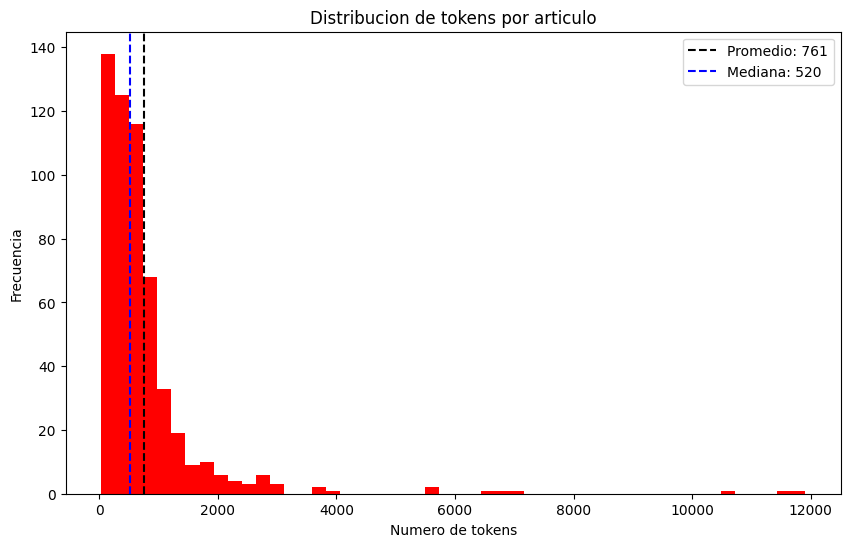

In [18]:
# Distribucion de tokens
plt.figure(figsize=(10, 6))
plt.hist(dataset["tokens"], bins=50, color="red")
plt.axvline(x=np.mean(dataset["tokens"]), color="black", linestyle="--", label=f"Promedio: {round(np.mean(dataset['tokens']))}")
plt.axvline(x=np.median(dataset["tokens"]), color="blue", linestyle="--", label=f"Mediana: {round(np.median(dataset['tokens']))}")
plt.title("Distribucion de tokens por articulo")
plt.xlabel("Numero de tokens")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

In [19]:
# Guardar el dataset
dataset.push_to_hub("codigo_penal")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jjovalle99/codigo_penal/commit/9386bdf5d0b442d528034b8f0c55b5d1edb552b6', commit_message='Upload dataset', commit_description='', oid='9386bdf5d0b442d528034b8f0c55b5d1edb552b6', pr_url=None, pr_revision=None, pr_num=None)

![img](../assets/hf_dataset.png)